In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
PRISM_PATH = "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/bin/prism"
STRATEGY_PATH = "/home/paul/Documents/probabilistic_games/adv.tra"

In [3]:
from journepy.src.preprocessing.greps import preprocessed_log
from journepy.src.alergia_utils import convert_utils

import probabilistic_game_utils as pgu 
#from src import game_construction
#from src import game_operations

from aalpy.learning_algs import run_Alergia
from aalpy.utils import save_automaton_to_file
from IPython.display import Image
from aalpy.utils import mdp_2_prism_format


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pm4py.objects.log.util import dataframe_utils

from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

import json

import networkx as nx

import subprocess

import numpy as np

In [4]:
filtered_log = preprocessed_log("data/data.csv", include_loggin=False) # also discards task-event log-in
filtered_log

Found types {'activate', 'subject', 'vpcInstance', 'state', 'resultsShared', 'latency', 'task', 'feedback', 'score'}
Includes #unsuccesfull: 16 and #succesfull 17
Variants before removing trivial elements
13


/home/paul/Documents/probabilistic_games/journepy/src/preprocessing/greps.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"loggedIn.*","loggedIn") # removes feedback attributes
/home/paul/Documents/probabilistic_games/journepy/src/preprocessing/greps.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"\[.*\]","") # removes feedback attributes


[[{'Company ID': 9, 'Category': 'B2B', 'time:timestamp': Timestamp('1970-01-27 15:22:16'), 'Type': 'state', 'concept:name': 'start', 'Unnamed: 6': nan, 'case:concept:name': '70'},
  {'Company ID': 9, 'Category': 'B2B', 'time:timestamp': Timestamp('1970-01-27 15:22:16'), 'Type': 'state', 'concept:name': 'registered', 'Unnamed: 6': nan, 'case:concept:name': '70'},
  {'Company ID': 9, 'Category': 'B2B', 'time:timestamp': Timestamp('1970-01-28 14:02:45'), 'Type': 'state', 'concept:name': 'activated', 'Unnamed: 6': nan, 'case:concept:name': '70'},
  {'Company ID': 9, 'Category': 'B2B', 'time:timestamp': Timestamp('1970-01-28 14:02:46'), 'Type': 'state', 'concept:name': 'vpcAssignInstance', 'Unnamed: 6': nan, 'case:concept:name': '70'},
  {'Company ID': 9, 'Category': 'B2B', 'time:timestamp': Timestamp('1970-01-28 14:02:46'), 'Type': 'state', 'concept:name': 'vpcCreateUserOnInstance', 'Unnamed: 6': nan, 'case:concept:name': '70'},
  {'Company ID': 9, 'Category': 'B2B', 'time:timestamp': Time

In [5]:
with open('data/activities_greps.xml') as f:
    data = f.read()
actors = json.loads(data)

In [6]:
actions_to_activities = {}
for a in actors:
    if actors[a] == "company":
        if a in ['vpcAssignInstance', 'Give feedback 0']: # todo: might be quite realistic?
            actions_to_activities[a] = "company"
        else:  
            actions_to_activities[a] = a
    else:
        if a == "negative":
            actions_to_activities[a] = a
        elif "Give feedback" in a or "Task event" in a:
            actions_to_activities[a] = a
        else:
            actions_to_activities[a] = "user"
print(actions_to_activities) 

{'Results automatically shared': 'Results automatically shared', 'Results shared': 'user', 'waitingForSubjectAcceptance': 'user', 'readyToStart': 'readyToStart', 'Give feedback 0': 'company', 'Give feedback 1': 'Give feedback 1', 'Give feedback 2': 'Give feedback 2', 'Give feedback 3': 'Give feedback 3', 'Give feedback 4': 'Give feedback 4', 'Give feedback 5': 'Give feedback 5', 'waitingForManualScores': 'waitingForManualScores', 'activated': 'activated', 'positive': 'positive', 'negative': 'negative', 'vpcCreateUserOnInstance': 'vpcCreateUserOnInstance', 'registered': 'user', 'Logged in: Web page': 'Logged in: Web page', 'started': 'started', 'start': 'start', 'subjectAcceptanceReceived': 'user', 'Task event: 0': 'Task event: 0', 'Task event: 1': 'Task event: 1', 'Task event: 2': 'Task event: 2', 'Task event: 3': 'Task event: 3', 'Task event: 4': 'Task event: 4', 'Task event: 5': 'Task event: 5', 'waitingForResultApproval': 'waitingForResultApproval', 'finished': 'finished', 'waitingF

## Alergia learning:
If input in format [O, (I,O), ...] automatically selects IO/Alergia as Alg.

In [7]:
# change from xes format
filtered_log_activities = [[e['concept:name'] for e in t] for t in filtered_log]
filtered_log_activities

[['start',
  'registered',
  'activated',
  'vpcAssignInstance',
  'vpcCreateUserOnInstance',
  'readyToStart',
  'started',
  'Task event: 0',
  'vpcAssignInstance',
  'vpcCreateUserOnInstance',
  'readyToStart',
  'started',
  'Task event: 0',
  'Give feedback 0',
  'Task event: 1',
  'Give feedback 1',
  'Task event: 2',
  'Give feedback 2',
  'Task event: 3',
  'Give feedback 3',
  'Task event: 4',
  'Give feedback 4',
  'Task event: 5',
  'waitingForManualScores',
  'waitingForScores',
  'waitingForResultApproval',
  'waitingForSubjectAcceptance',
  'subjectAcceptanceReceived',
  'Results automatically shared',
  'waitingForActivityReport',
  'negative'],
 ['start',
  'registered',
  'activated',
  'vpcAssignInstance',
  'vpcCreateUserOnInstance',
  'readyToStart',
  'started',
  'Task event: 0',
  'Give feedback 0',
  'Task event: 1',
  'Give feedback 1',
  'Task event: 2',
  'Give feedback 2',
  'Task event: 3',
  'Give feedback 3',
  'Task event: 4',
  'waitingForManualScores',

In [8]:
#diff when using actors and actions_to_activities
# under actors:
# - task event 4 / 5 exists double under "actors" 
# - and vpcCreateUser "diamond" is resolved to be det.
data = [[(actions_to_activities[t[i]], t[i]) for i in range(1, len(t))] for t in filtered_log_activities]
for d in data:
    d.insert(0, 'start')
    #d.append(d[-1]) # doubles last element
data

[['start',
  ('user', 'registered'),
  ('activated', 'activated'),
  ('company', 'vpcAssignInstance'),
  ('vpcCreateUserOnInstance', 'vpcCreateUserOnInstance'),
  ('readyToStart', 'readyToStart'),
  ('started', 'started'),
  ('Task event: 0', 'Task event: 0'),
  ('company', 'vpcAssignInstance'),
  ('vpcCreateUserOnInstance', 'vpcCreateUserOnInstance'),
  ('readyToStart', 'readyToStart'),
  ('started', 'started'),
  ('Task event: 0', 'Task event: 0'),
  ('company', 'Give feedback 0'),
  ('Task event: 1', 'Task event: 1'),
  ('Give feedback 1', 'Give feedback 1'),
  ('Task event: 2', 'Task event: 2'),
  ('Give feedback 2', 'Give feedback 2'),
  ('Task event: 3', 'Task event: 3'),
  ('Give feedback 3', 'Give feedback 3'),
  ('Task event: 4', 'Task event: 4'),
  ('Give feedback 4', 'Give feedback 4'),
  ('Task event: 5', 'Task event: 5'),
  ('waitingForManualScores', 'waitingForManualScores'),
  ('waitingForScores', 'waitingForScores'),
  ('waitingForResultApproval', 'waitingForResultAppro

In [9]:
model = run_Alergia(data, automaton_type='mdp', eps=0.9, print_info=True)

PTA Construction Time:  0.0
Alergia Learning Time: 0.0
Alergia Learned 29 state automaton.


In [10]:
filename = "greps/greps-example_2"
save_automaton_to_file(model, f"{filename}.dot")
save_automaton_to_file(model, f"{filename}.png", file_type="png")

Model saved to greps/greps-example_2.dot.
Model saved to greps/greps-example_2.png.


Model contains some inconsistencies, e.g. repeating the same test, i.e. test 4 (give feedback 4).

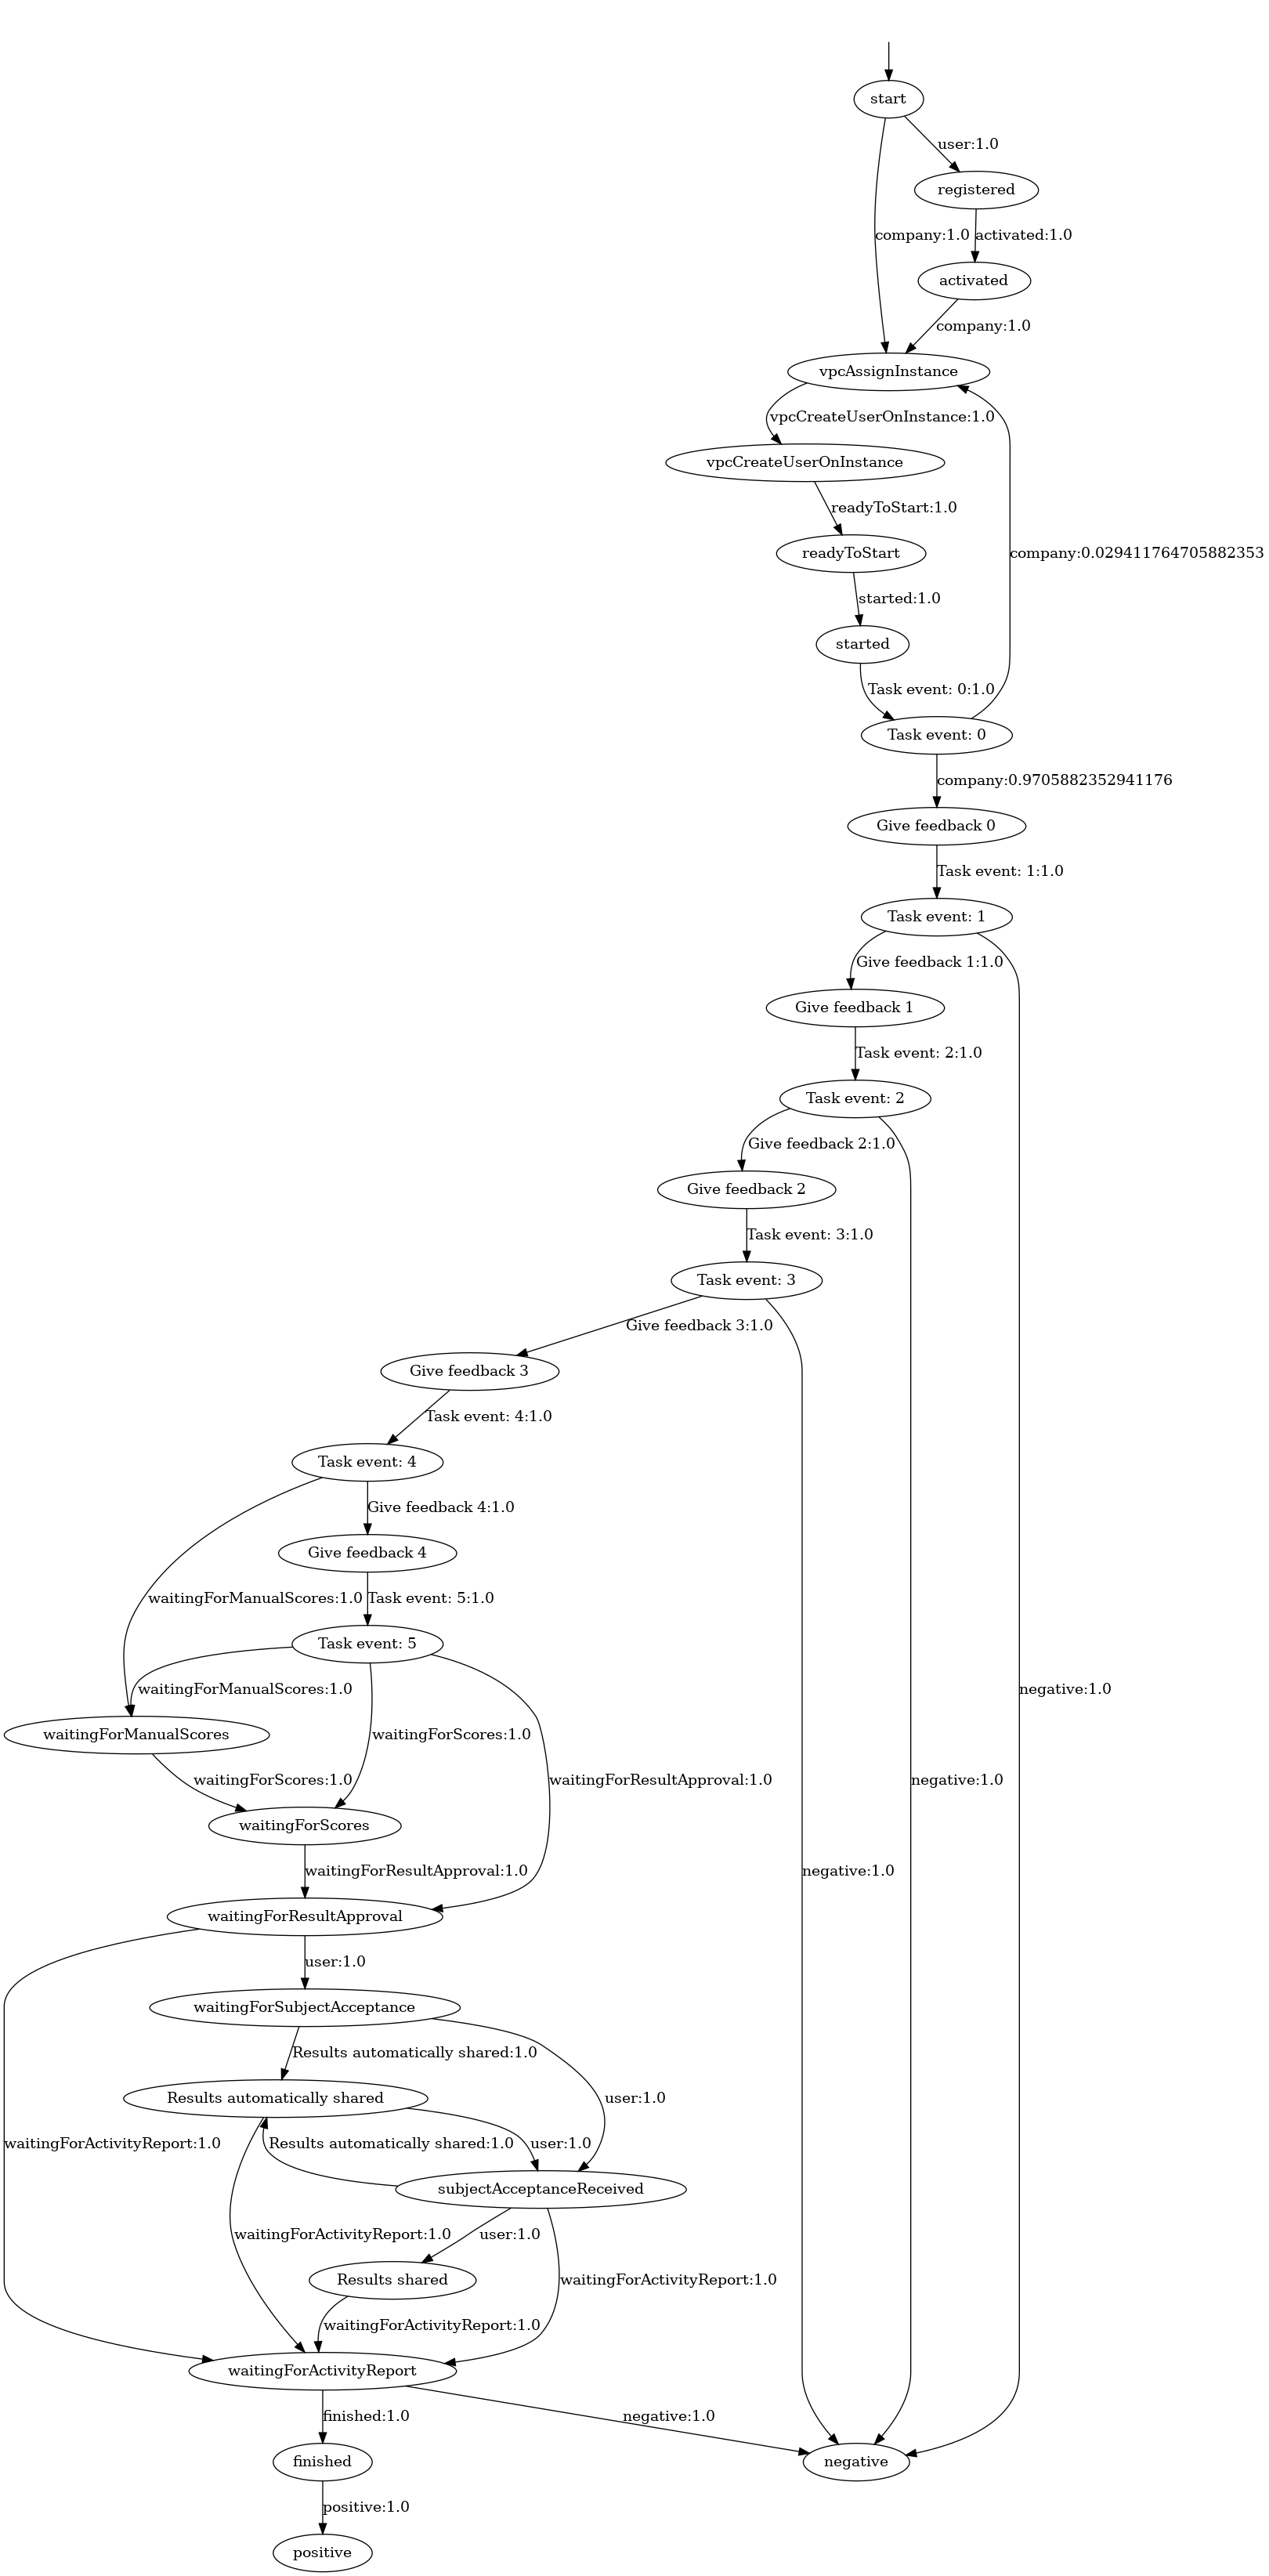

In [11]:
Image(f"{filename}.png")

In [12]:
# quantify environment -> becomes MDP, could leave some non-det? -> look into def in paper
data_environment = []
for trace in data:
    current = [trace[0]]
    for i in range(1, len(trace)):
        e = trace[i]
        previous_state = "start" if i == 1 else trace[i-1][1]
        #print(d[i-1])
        # encode environment with following decision
        #current.append(('environment', "environment"+ previous_state))
        #current.append(("environment"+ previous_state, d[i][0]+previous_state))
        
        # encode decision in one step
        current.append(('env', actors[e[1]] + previous_state))
        current.append(e)
    data_environment.append(current)

data_environment

[['start',
  ('env', 'customerstart'),
  ('user', 'registered'),
  ('env', 'companyregistered'),
  ('activated', 'activated'),
  ('env', 'companyactivated'),
  ('company', 'vpcAssignInstance'),
  ('env', 'companyvpcAssignInstance'),
  ('vpcCreateUserOnInstance', 'vpcCreateUserOnInstance'),
  ('env', 'companyvpcCreateUserOnInstance'),
  ('readyToStart', 'readyToStart'),
  ('env', 'companyreadyToStart'),
  ('started', 'started'),
  ('env', 'customerstarted'),
  ('Task event: 0', 'Task event: 0'),
  ('env', 'companyTask event: 0'),
  ('company', 'vpcAssignInstance'),
  ('env', 'companyvpcAssignInstance'),
  ('vpcCreateUserOnInstance', 'vpcCreateUserOnInstance'),
  ('env', 'companyvpcCreateUserOnInstance'),
  ('readyToStart', 'readyToStart'),
  ('env', 'companyreadyToStart'),
  ('started', 'started'),
  ('env', 'customerstarted'),
  ('Task event: 0', 'Task event: 0'),
  ('env', 'companyTask event: 0'),
  ('company', 'Give feedback 0'),
  ('env', 'customerGive feedback 0'),
  ('Task event: 

In [13]:
model_environment = run_Alergia(data_environment, automaton_type='mdp', eps=0.1, print_info=True)
# same number of states (might be same model)

PTA Construction Time:  0.0
Alergia Learning Time: 0.01
Alergia Learned 65 state automaton.


In [14]:
filename = "greps/greps-example_environment_actions"
save_automaton_to_file(model_environment, f"{filename}.dot")
save_automaton_to_file(model_environment, f"{filename}.png", file_type="png")

Model saved to greps/greps-example_environment_actions.dot.


Model saved to greps/greps-example_environment_actions.png.


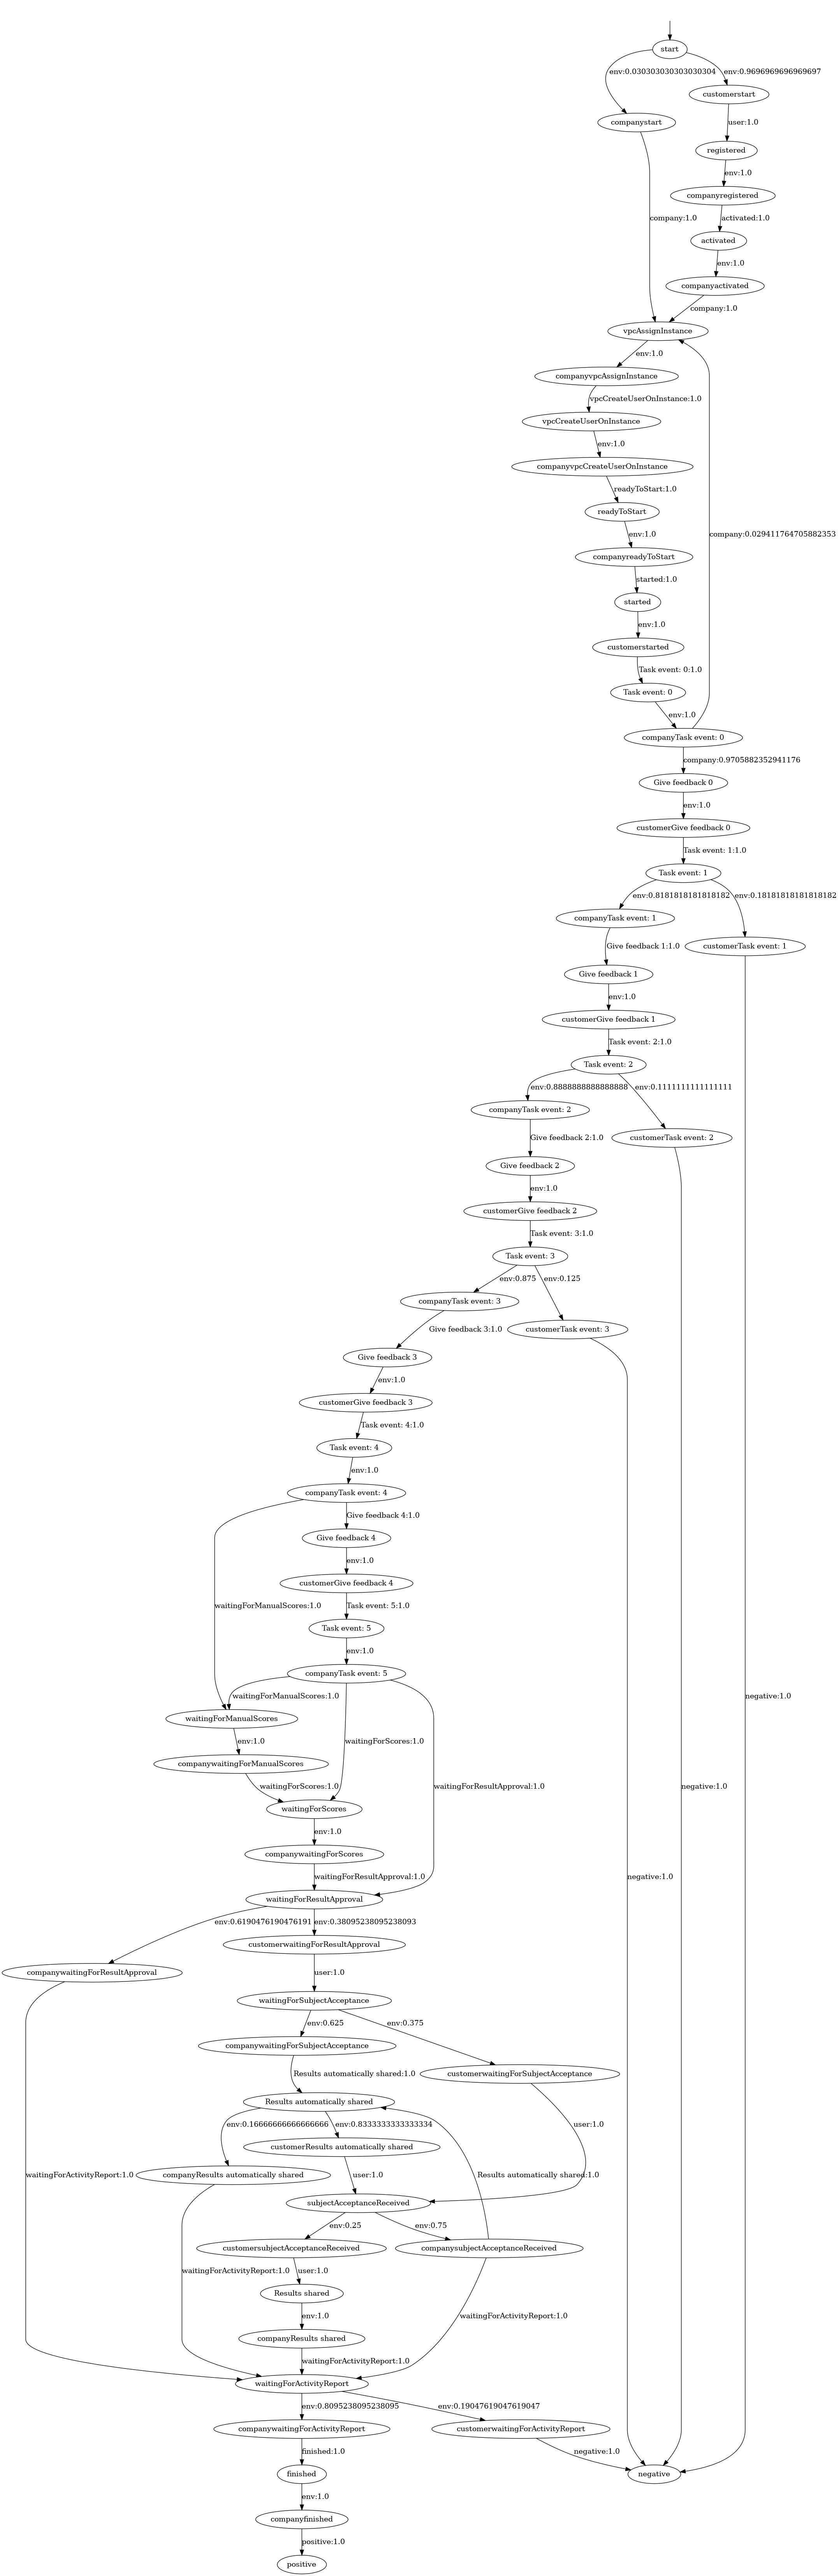

In [15]:
Image(f"{filename}.png")

## Map to networkx graph

In [16]:
filename = "greps"
prism_repr = mdp_2_prism_format(model, f'learned_model_{filename}')

print(prism_repr)

mdp
module learned_model_greps
loc : [0..29] init 0;
[user] loc=0 -> 
 1.0 : (loc'=2);
[company] loc=0 -> 
 1.0 : (loc'=1);
[vpcCreateUserOnInstance] loc=1 -> 
 1.0 : (loc'=3);
[activated] loc=2 -> 
 1.0 : (loc'=4);
[readyToStart] loc=3 -> 
 1.0 : (loc'=5);
[company] loc=4 -> 
 1.0 : (loc'=1);
[started] loc=5 -> 
 1.0 : (loc'=6);
[Task event: 0] loc=6 -> 
 1.0 : (loc'=7);
[company] loc=7 -> 
 0.9705882352941176 : (loc'=8) + 0.029411764705882353 : (loc'=1);
[Task event: 1] loc=8 -> 
 1.0 : (loc'=9);
[Give feedback 1] loc=9 -> 
 1.0 : (loc'=10);
[negative] loc=9 -> 
 1.0 : (loc'=12);
[Task event: 2] loc=10 -> 
 1.0 : (loc'=11);
[negative] loc=11 -> 
 1.0 : (loc'=12);
[Give feedback 2] loc=11 -> 
 1.0 : (loc'=13);
[Task event: 3] loc=13 -> 
 1.0 : (loc'=14);
[Give feedback 3] loc=14 -> 
 1.0 : (loc'=15);
[negative] loc=14 -> 
 1.0 : (loc'=12);
[Task event: 4] loc=15 -> 
 1.0 : (loc'=16);
[waitingForManualScores] loc=16 -> 
 1.0 : (loc'=18);
[Give feedback 4] loc=16 -> 
 1.0 : (loc'=17);
[

In [17]:
g = convert_utils.mdp_to_nx(model_environment, actors)

source: q0: start
for action: env
reaching state q2: customerstart
with prob: 0.9696969696969697
is controllable False
reaching state q1: companystart
with prob: 0.030303030303030304
is controllable False
source: q1: companystart
for action: company
reaching state q3: vpcAssignInstance
with prob: 1.0
is controllable True
source: q2: customerstart
for action: user
reaching state q4: registered
with prob: 1.0
is controllable False
source: q3: vpcAssignInstance
for action: env
reaching state q5: companyvpcAssignInstance
with prob: 1.0
is controllable False
source: q4: registered
for action: env
reaching state q6: companyregistered
with prob: 1.0
is controllable False
source: q5: companyvpcAssignInstance
for action: vpcCreateUserOnInstance
reaching state q7: vpcCreateUserOnInstance
with prob: 1.0
is controllable True
source: q6: companyregistered
for action: activated
reaching state q8: activated
with prob: 1.0
is controllable True
source: q7: vpcCreateUserOnInstance
for action: env
reachi

In [18]:
#g = pgu.add_neutral_user_transition(g, debug = True)

In [19]:
g = pgu.add_gas_and_user_count(g, data_environment)

('q0: start', 'q2: customerstart') {'action': 'env', 'prob_weight': 0.9696969696969697, 'controllable': False, 'count': 32, 'gas': -41.43607977885285, 'trace_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32]}
('q0: start', 'q1: companystart') {'action': 'env', 'prob_weight': 0.030303030303030304, 'controllable': False, 'count': 1, 'gas': -242.0, 'trace_indices': [31]}
('q2: customerstart', 'q4: registered') {'action': 'user', 'prob_weight': 1.0, 'controllable': False, 'count': 32, 'gas': -41.43607977885285, 'trace_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32]}
('q1: companystart', 'q3: vpcAssignInstance') {'action': 'company', 'prob_weight': 1.0, 'controllable': True, 'count': 1, 'gas': -242.0, 'trace_indices': [31]}
('q3: vpcAssignInstance', 'q5: companyvpcAssignInstance') {'action': 'env', 'prob_weight': 1.0, 'controllable':

# Write to prism

In [41]:
from journepy.src.mc_utils.prism_utils import PrismPrinter
from journepy.src.mc_utils.prism_utils import PrismQuery

In [42]:
printer = PrismPrinter(g, "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/", "alergia_reduction_model.prism")
printer.write_to_prism()

In [43]:
print(g.nodes())

['q0: start', 'q2: customerstart', 'q1: companystart', 'q3: vpcAssignInstance', 'q4: registered', 'q5: companyvpcAssignInstance', 'q6: companyregistered', 'q7: vpcCreateUserOnInstance', 'q8: activated', 'q9: companyvpcCreateUserOnInstance', 'q10: companyactivated', 'q11: readyToStart', 'q12: companyreadyToStart', 'q13: started', 'q14: customerstarted', 'q15: Task event: 0', 'q16: companyTask event: 0', 'q17: Give feedback 0', 'q18: customerGive feedback 0', 'q19: Task event: 1', 'q20: companyTask event: 1', 'q25: customerTask event: 1', 'q21: Give feedback 1', 'q22: customerGive feedback 1', 'q23: Task event: 2', 'q24: customerTask event: 2', 'q27: companyTask event: 2', 'q26: negative', 'q28: Give feedback 2', 'q29: customerGive feedback 2', 'q30: Task event: 3', 'q31: companyTask event: 3', 'q32: customerTask event: 3', 'q33: Give feedback 3', 'q34: customerGive feedback 3', 'q35: Task event: 4', 'q36: companyTask event: 4', 'q38: waitingForManualScores', 'q37: Give feedback 4', 'q39

In [44]:
source = [s for s in g if 'start' == s.split(' ')[1]]
target = [s for s in g if 'positive' in s]
assert len(source) == 1 and len(target) == 1
print(len(nx.shortest_path(g, source=source[0], target=target[0]))) # includes start and target -> # 19 interact.
# prism in exp. 20.6 (includes env. changes to do nothin)

39


In [45]:
query = PrismQuery(g, "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/", "alergia_reduction_model.prism", PRISM_PATH)

In [46]:
results_file = query.query("/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props")

# adapt results_file to original graph (printer.g. has renamed states)
#isomophism = nx.vf2pp_isomorphism(printer.g, g, node_label=None)
#results_file = {isomophism[r] : results_file[r] for r in results_file}

#for r in results_file:
#    print(r, results_file[r])

AttributeError: Can only use .str accessor with string values!

In [ ]:
from journepy.src.mc_utils.prism_utils import PrismQuery
query = PrismQuery(g, "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/", "alergia_reduction_model.prism", PRISM_PATH)

In [ ]:
strategy = query.get_strategy("/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props")
strategy

{'q0start': 'env',
 'q2customerstart': 'user',
 'q1companystart': 'company',
 'q3vpcAssignInstance': 'env',
 'q4registered': 'env',
 'q5companyvpcAssignInstance': 'vpcCreateUserOnInstance',
 'q6companyregistered': 'activated',
 'q7vpcCreateUserOnInstance': 'env',
 'q8activated': 'env',
 'q9companyvpcCreateUserOnInstance': 'readyToStart',
 'q10companyactivated': 'company',
 'q11readyToStart': 'env',
 'q12companyreadyToStart': 'started',
 'q13started': 'env',
 'q14customerstarted': 'Taskevent0',
 'q15Taskevent0': 'env',
 'q16companyTaskevent0': 'company',
 'q17Givefeedback0': 'env',
 'q18customerGivefeedback0': 'Taskevent1',
 'q19Taskevent1': 'env',
 'q20companyTaskevent1': 'Givefeedback1',
 'q25customerTaskevent1': 'negative',
 'q21Givefeedback1': 'env',
 'q22customerGivefeedback1': 'Taskevent2',
 'q23Taskevent2': 'env',
 'q24customerTaskevent2': 'negative',
 'q27companyTaskevent2': 'Givefeedback2',
 'q28Givefeedback2': 'env',
 'q29customerGivefeedback2': 'Taskevent3',
 'q30Taskevent3':

In [ ]:
def can_be_merged(g, results_file):
    for s in g.nodes():
        reachable_values = [round(results_file[t],2) for t in g[s]]
        if round(results_file[s],2) in reachable_values:
        #if len(set(reachable_values)) == 1 and reachable_values[0] == round(results_file[s],2):
            return s 
    return None

"""
NOTE: One positive and one negative node is kept and all remaining from positive/negative cluster are merged into them.
"""
def reduce_graph(g, results_file):
    neg_cluster = []
    pos_cluster = []
    print("size start", len(g.nodes()))
    s = can_be_merged(g, results_file)
    while(s != None):
        for t in g[s]:
            if round(results_file[t],2) != round(results_file[s],2):
                continue
            g = nx.contracted_nodes(g, s, t, self_loops = False)
        s = can_be_merged(g, results_file)

    for s in g:
        if results_file[s] == 0:
            neg_cluster.append(s)
        if results_file[s] == 1:
            pos_cluster.append(s)
    for s in pos_cluster[1:]:
        g = nx.contracted_nodes(g, pos_cluster[0], s, self_loops=False)
    for s in neg_cluster[1:]:
        g = nx.contracted_nodes(g, neg_cluster[0], s, self_loops=False)



    g.remove_edges_from(nx.selfloop_edges(g))

    print("size reduced", len(g.nodes()))
    return g

In [ ]:
from  matplotlib.colors import LinearSegmentedColormap # for color map
from matplotlib.colors import rgb2hex

def compute_color_map(g, results_file):
    c = ["darkred","red","lightcoral", "palegreen","green","darkgreen"]
    v = [0,0.15,0.4,0.6,0.9,1]
    l = list(zip(v,c))
    cmap=LinearSegmentedColormap.from_list('rg',l, N=256)
    s = cmap(0.23)
    map = {}
    for s in g.nodes():
        map[s] = rgb2hex(cmap(results_file[s])) # have to convert to hex color
    return map

def draw_dfg(g, name, names={}, layout = "sfdp", color_map = []):
    scaling = 10
    # build graph with variable thicknes
    #scaling = 1/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')
    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
    for e in g.edges:
        if 'controllable' in g[e[0]][e[1]]:
            if not g[e[0]][e[1]]['controllable']:
                edge = A.get_edge(e[0], e[1])
                edge.attr["style"] = "dotted"
                #edge.attr["label"] =  str(g[e[0]][e[1]]["prob_weight"])
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)

    #A.graph_attr.update(size="7.75,10.25")

    for n in A.nodes():
        if n in names:
            new = names[n]
            if isinstance(names[n], float): 
                new = round(names[n], 2)
            n.attr['label'] = new
            #if new == 1:
            #    n.attr['label'] = "pos"
            #elif new == 0:
            #    n.attr['label'] = "neg"
            #else:
            #    n.attr["label"] = "" # uncomment to print state names
        if n in color_map:
            n.attr['color'] = color_map[n]
    
        n.attr['fontsize'] = 80
        n.attr['penwidth'] = 20
        n.attr['height'] = 2
        n.attr['width'] = 2

    for e in A.edges():
        e.attr['penwidth'] = 15
        e.attr["fontsize"] = 80
        e.attr["label"] = str(g[e[0]][e[1]]["prob_weight"])
        e.attr["color"] = "black"
            
    A.write(name.split(".")[0]+".dot")
    A.layout(layout)
    A.draw(name)
    print("Plotted", name)

In [ ]:
def get_probs_file(results_file, g):
    isomophism = nx.vf2pp_isomorphism(printer.g, g, node_label=None)
    results_file = {isomophism[r] : results_file[r] for r in results_file}
    return results_file

print(g.nodes())
draw_dfg(g, "greps/alergia_probs.png", get_probs_file(results_file, g), layout = "dot")

['q0: start', 'q2: customerstart', 'q1: companystart', 'q3: vpcAssignInstance', 'q4: registered', 'q5: companyvpcAssignInstance', 'q6: companyregistered', 'q7: vpcCreateUserOnInstance', 'q8: activated', 'q9: companyvpcCreateUserOnInstance', 'q10: companyactivated', 'q11: readyToStart', 'q12: companyreadyToStart', 'q13: started', 'q14: customerstarted', 'q15: Task event: 0', 'q16: companyTask event: 0', 'q17: Give feedback 0', 'q18: customerGive feedback 0', 'q19: Task event: 1', 'q20: companyTask event: 1', 'q25: customerTask event: 1', 'q21: Give feedback 1', 'q22: customerGive feedback 1', 'q23: Task event: 2', 'q24: customerTask event: 2', 'q27: companyTask event: 2', 'q26: negative', 'q28: Give feedback 2', 'q29: customerGive feedback 2', 'q30: Task event: 3', 'q31: companyTask event: 3', 'q32: customerTask event: 3', 'q33: Give feedback 3', 'q34: customerGive feedback 3', 'q35: Task event: 4', 'q36: companyTask event: 4', 'q38: waitingForManualScores', 'q37: Give feedback 4', 'q39

In [ ]:
import copy
def plot_reduction(g, name, results_file, layout = "sdf"):
    g = copy.deepcopy(g)
    g = reduce_graph(g, results_file)
    color_map = compute_color_map(g, results_file)
    draw_dfg(g, name, names = results_file, layout = layout, color_map=color_map)
plot_reduction(g, "greps/alergia_reduced.png", get_probs_file(results_file, g), layout = "dot")

size start 65
size reduced 6
Plotted greps/alergia_reduced.png


### Constrained steps and parameterized transitions

In [47]:
query = PrismQuery(g, "/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/", "alergia_reduction_model_param.prism", PRISM_PATH)
results_file = query.query("/home/paul/Downloads/prism-games-3.2.1-linux64-x86/generated/queries/pos_alergia.props", write_attributes=True, write_parameterized=True, envprob=0.4)
results_file

AttributeError: Can only use .str accessor with string values!

## Lost users & repair recommendations
-> not re-implemented so far, not sure if best approach to problem...

In [ ]:
def lost_users(g, results_file, edge_mapping, strategy):
    #search for "to-repair" edges
    users_lost = {}
    users_lost_edge = {}
    for s in g.nodes():
        in_sum = 0
        for e in g.in_edges(s):
            assert(e[0] in strategy)
            if e[1] not in strategy[e[0]]:
                continue # skip "avoidable" edges in recommendations
            prob = 1
            if not g[e[0]][e[1]]["controllable"]:
                out_sum = 0
                for out_edge in g[e[0]]:
                    if not g[e[0]][out_edge]["controllable"]:
                        out_sum += g[e[0]][out_edge]["prob_weight"]
                prob = len(edge_mapping[e]) / out_sum
            in_sum += len(edge_mapping[e])*(results_file[e[0]]-results_file[e[1]])* prob
            #if g[e[0]][e[1]]["controllable"]:
            #    print(len(edge_mapping[e])*(results_file[e[0]]-results_file[e[1]]))
            users_lost_edge[e] = len(edge_mapping[e])*(results_file[e[0]]-results_file[e[1]])*prob
        users_lost[s] = (1-results_file[s])*in_sum
    return users_lost, users_lost_edge

In [ ]:
def plot_repair_recommendations(g, states, q, edge_mapping):
    strategy = get_strategy(g, states)
    results_file = compute_reduction(g, states, q = q)
    users_lost, users_lost_edge = lost_users(g, results_file, edge_mapping, strategy)

    sorted_edges = [(k,v) for k, v in sorted(users_lost_edge.items(), key=lambda item: item[1], reverse=True)]
    total = sum([k[1] for k in sorted_edges if k[1] > 0])
    print("total", total)
    print("ratio", total/sum([k[1] for k in sorted_edges if k[1] < 0]))
    weights = []
    names = []
    for i in range(5):
        print(sorted_edges[i], sorted_edges[i][1]/total)
        weights.append(sorted_edges[i][1])
        names.append(str(sorted_edges[i][0]))
    colors = ["red" if "TIMEOUT" in name else "orange" if "Call" in name else "green" for name in names]
    plt.scatter(range(len(weights)),weights, c = colors)
    plt.show()

    timeout_lost = 0
    offer_call_lost = 0
    incomplete_call_lost = 0
    for k,v in sorted_edges:
        if "TIMEOUT" in k[1]:
            timeout_lost += v
        if "W_Call after offers" in k[1].split("-")[-1]:
            offer_call_lost += v
        if "W_Call incomplete files" in k[1].split("-")[-1]:
            incomplete_call_lost += v

    print("timeout", timeout_lost/total)
    print("offer call", offer_call_lost/total)
    print("incomplete call", incomplete_call_lost/total)
    return {k : v for (k,v) in sorted_edges[:5]}